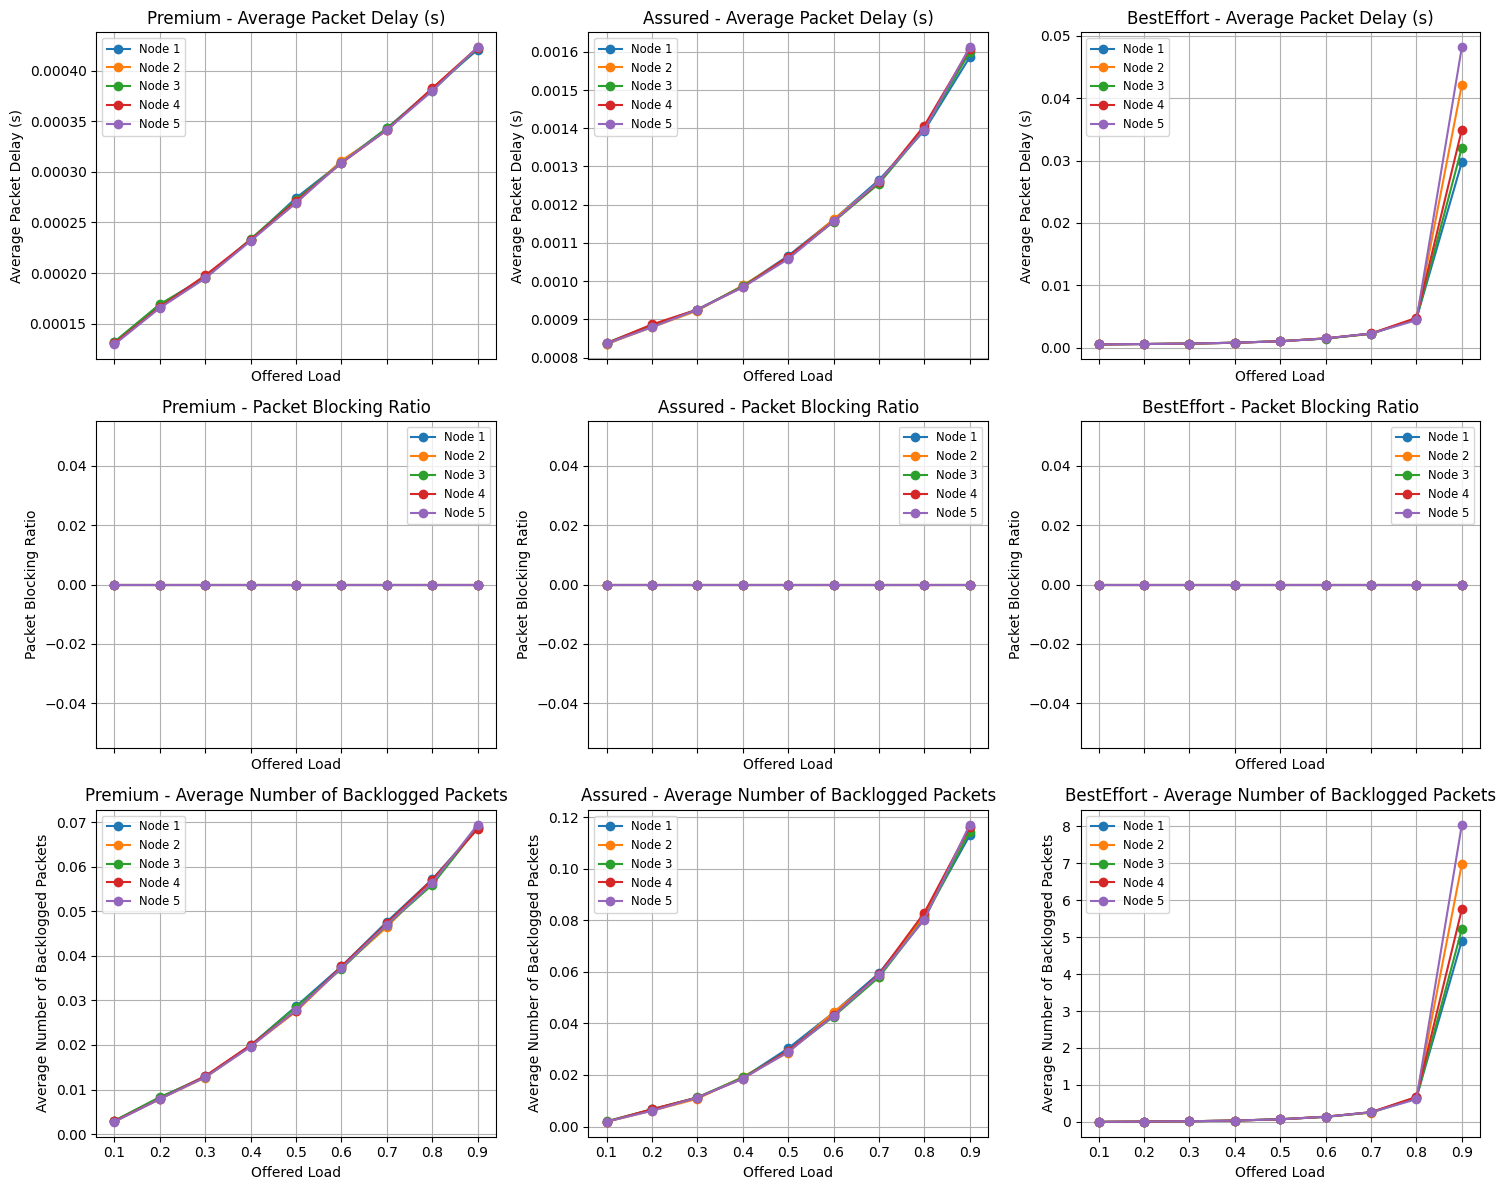

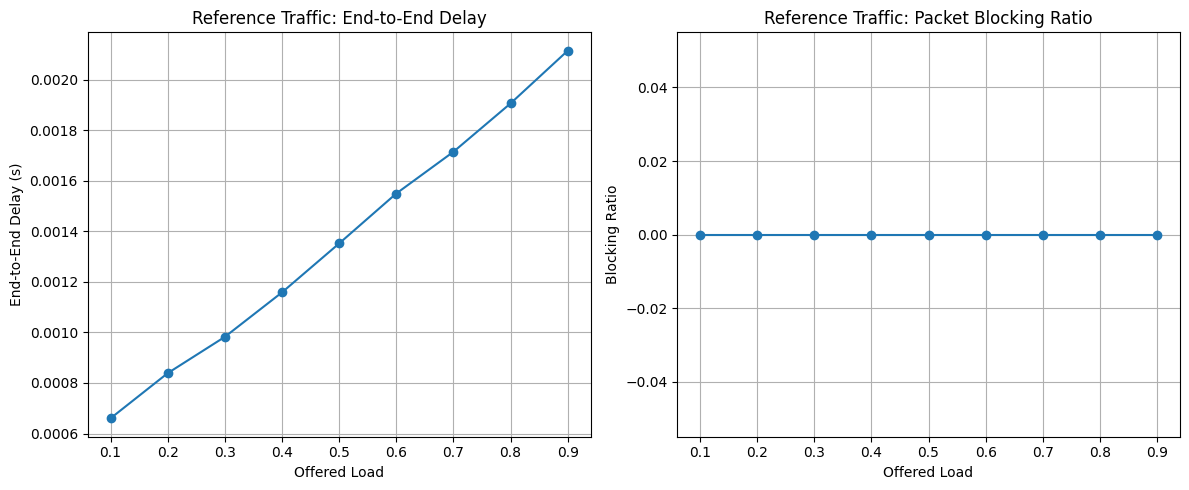

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the provided read_results function is defined
def read_results(file_path):
    """
    Reads a CSV file containing mixed node-level and reference rows.
    Node-level rows are expected to have 9 columns:
      OfferedLoad, Node, QueueType, AvgDelay, BlockingRatio, AvgBacklog, N_audio, N_video, N_data
    Reference rows have 4 columns:
      OfferedLoad, Node, Metric, Value
    
    Returns two DataFrames: one for node-level data and one for reference data.
    """
    node_data = []
    ref_data = []
    
    with open(file_path, 'r') as f:
        header = None
        for line in f:
            line = line.strip()
            if not line:
                continue
            # Process header if present
            if header is None and line.startswith("OfferedLoad"):
                header = line.split(',')
                continue
            parts = line.split(',')
            # For node-level data, expect 9 columns
            if len(parts) == 9:
                try:
                    record = {
                        'OfferedLoad': float(parts[0]),
                        'Node': parts[1],  # keep as string
                        'QueueType': parts[2],
                        'AvgDelay': float(parts[3]),
                        'BlockingRatio': float(parts[4]),
                        'AvgBacklog': float(parts[5]),
                        'N_audio': int(parts[6]),
                        'N_video': int(parts[7]),
                        'N_data': int(parts[8])
                    }
                    node_data.append(record)
                except Exception as e:
                    continue
            # For reference data, expect 4 columns
            elif len(parts) == 4:
                try:
                    record = {
                        'OfferedLoad': float(parts[0]),
                        'Node': parts[1],  # expected to be "Reference"
                        'Metric': parts[2],
                        'Value': float(parts[3])
                    }
                    ref_data.append(record)
                except Exception as e:
                    continue
            else:
                continue

    df_node = pd.DataFrame(node_data)
    df_ref = pd.DataFrame(ref_data)
    return df_node, df_ref

# Read the simulation results CSV file (change the file path as needed)
csv_file = 'results_scenario1.csv'
df_node, df_ref = read_results(csv_file)

# -------------------------------------------
# 1. Visualization of Node-Level Metrics
# -------------------------------------------
# We want to plot for each priority queue the following metrics vs. offered load:
# (a) Average Packet Delay, (b) Packet Blocking Ratio, (c) Average Number of Backlogged Packets.
# Since the simulation is set up with 5 nodes and an infinite buffer, the graphs are expected
# to be identical (or nearly so) for all nodes. Any differences may be due to simulation randomness.
metrics = {
    'AvgDelay': 'Average Packet Delay (s)',
    'BlockingRatio': 'Packet Blocking Ratio',
    'AvgBacklog': 'Average Number of Backlogged Packets'
}

queue_types = ['Premium', 'Assured', 'BestEffort']

# Create a 3x3 grid of subplots: rows for each metric, columns for each queue type.
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), sharex=True)

for col, queue in enumerate(queue_types):
    # Select the node-level data corresponding to the current priority queue.
    df_queue = df_node[df_node['QueueType'] == queue]
    
    # Get the list of nodes (converted to int for proper ordering)
    nodes = sorted(df_queue['Node'].unique(), key=lambda x: int(x))
    
    for row, metric in enumerate(metrics.keys()):
        ax = axs[row, col]
        for node in nodes:
            # For each node, select the data and sort by offered load.
            subset = df_queue[df_queue['Node'] == node].sort_values('OfferedLoad')
            ax.plot(subset['OfferedLoad'], subset[metric], marker='o', label=f'Node {node}')
        ax.set_title(f'{queue} - {metrics[metric]}')
        ax.set_xlabel('Offered Load')
        ax.set_ylabel(metrics[metric])
        ax.grid(True)
        ax.legend(fontsize='small')
        
plt.tight_layout()
plt.show()

# -------------------------------------------
# 2. Visualization of Reference Traffic Metrics
# -------------------------------------------
# The reference traffic data contains the end-to-end delay and overall blocking ratio for
# reference packets. We pivot the dataframe so that we have columns for each metric.
ref_pivot = df_ref.pivot(index='OfferedLoad', columns='Metric', values='Value').reset_index()

# Create a figure with two subplots for reference traffic.
fig2, axs2 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# (d) Plot the average end-to-end delay versus offered load.
axs2[0].plot(ref_pivot['OfferedLoad'], ref_pivot['EndToEndDelay'], marker='o', linestyle='-')
axs2[0].set_title('Reference Traffic: End-to-End Delay')
axs2[0].set_xlabel('Offered Load')
axs2[0].set_ylabel('End-to-End Delay (s)')
axs2[0].grid(True)
# Optionally, if you have a theoretical average delay from Fig. 6, add it here:
# theoretical_delay = ...  # define or compute theoretical delay
# axs2[0].axhline(y=theoretical_delay, color='red', linestyle='--', label='Theoretical Average')
# axs2[0].legend()

# (e) Plot the overall packet blocking ratio for reference traffic versus offered load.
axs2[1].plot(ref_pivot['OfferedLoad'], ref_pivot['BlockingRatio'], marker='o', linestyle='-')
axs2[1].set_title('Reference Traffic: Packet Blocking Ratio')
axs2[1].set_xlabel('Offered Load')
axs2[1].set_ylabel('Blocking Ratio')
axs2[1].grid(True)

plt.tight_layout()
plt.show()


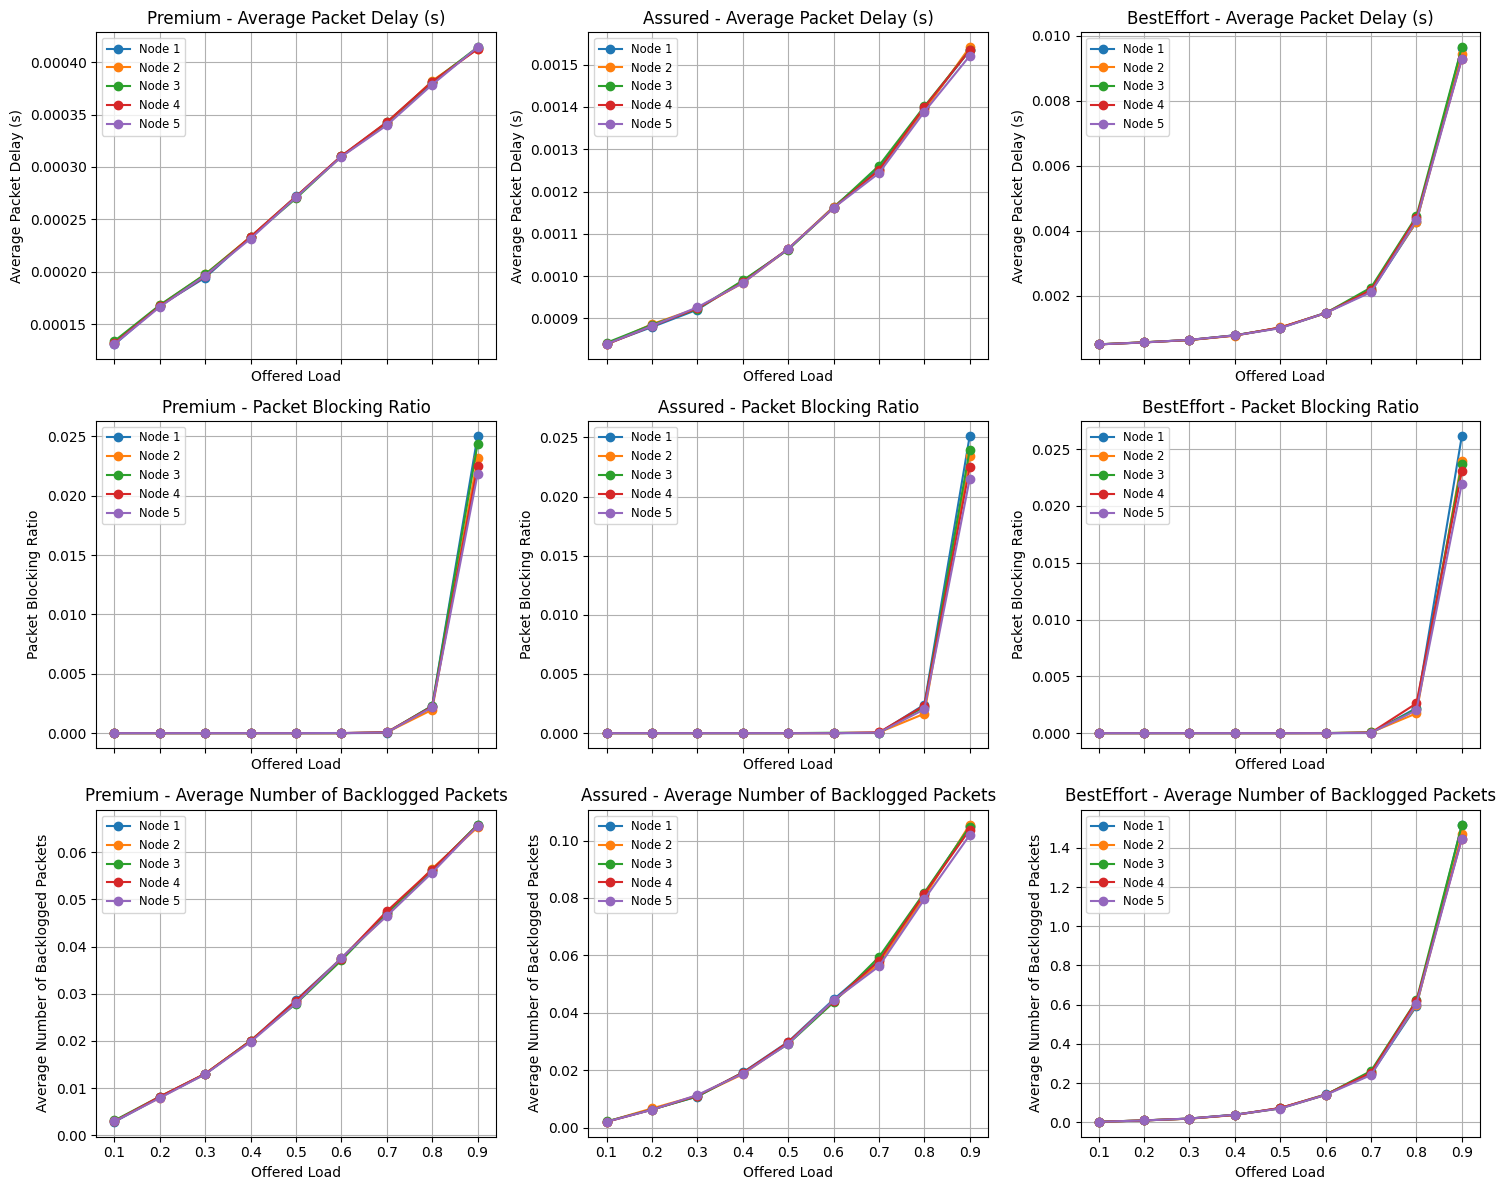

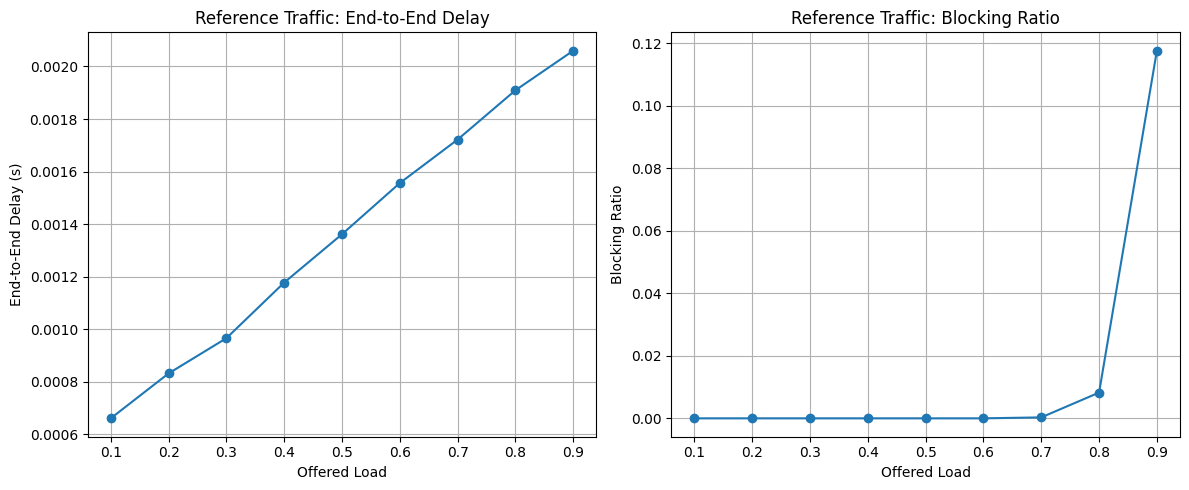

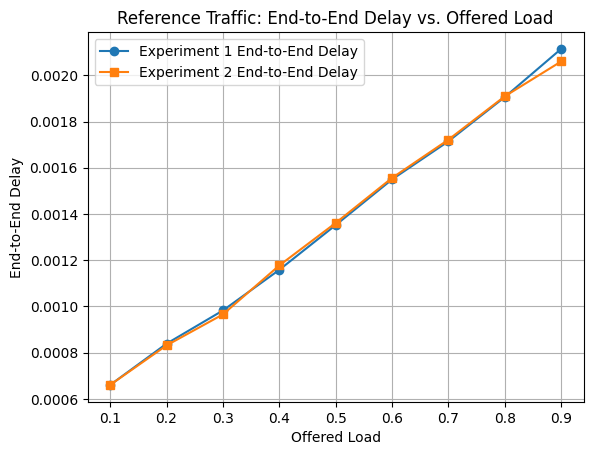

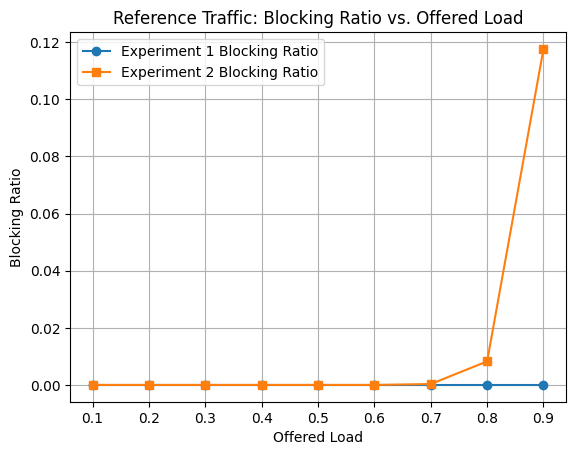

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


# Set the CSV file path for Experiment 2 (update this path if needed)
csv_file = 'results_scenario2.csv'
df_node, df_ref = read_results(csv_file)

# ------------------------------
# 1. Visualization: Node-Level Metrics
# ------------------------------
# For each priority queue, we plot the following versus offered load:
# (a) Average Packet Delay, (b) Packet Blocking Ratio, (c) Average Number of Backlogged Packets.
# With a finite queue size, the blocking ratio may start to rise at higher offered loads.
metrics = {
    'AvgDelay': 'Average Packet Delay (s)',
    'BlockingRatio': 'Packet Blocking Ratio',
    'AvgBacklog': 'Average Number of Backlogged Packets'
}
queue_types = ['Premium', 'Assured', 'BestEffort']

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), sharex=True)

for col, queue in enumerate(queue_types):
    # Filter data for the current priority queue.
    df_queue = df_node[df_node['QueueType'] == queue]
    # Sort node labels numerically
    nodes = sorted(df_queue['Node'].unique(), key=lambda x: int(x))
    
    for row, metric in enumerate(metrics.keys()):
        ax = axs[row, col]
        for node in nodes:
            subset = df_queue[df_queue['Node'] == node].sort_values('OfferedLoad')
            ax.plot(subset['OfferedLoad'], subset[metric], marker='o', label=f'Node {node}')
        ax.set_title(f'{queue} - {metrics[metric]}')
        ax.set_xlabel('Offered Load')
        ax.set_ylabel(metrics[metric])
        ax.grid(True)
        ax.legend(fontsize='small')
        
plt.tight_layout()
plt.show()

# ------------------------------
# 2. Visualization: Reference Traffic Metrics
# ------------------------------
# Pivot the reference data so that each metric becomes a column.
ref_pivot = df_ref.pivot(index='OfferedLoad', columns='Metric', values='Value').reset_index()

fig2, axs2 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# (d) Plot the average end-to-end delay vs. offered load.
axs2[0].plot(ref_pivot['OfferedLoad'], ref_pivot['EndToEndDelay'], marker='o', linestyle='-')
axs2[0].set_title('Reference Traffic: End-to-End Delay')
axs2[0].set_xlabel('Offered Load')
axs2[0].set_ylabel('End-to-End Delay (s)')
axs2[0].grid(True)
# Optionally add a line for the theoretical average delay if available:
# axs2[0].axhline(y=theoretical_delay, color='red', linestyle='--', label='Theoretical Average')
# axs2[0].legend()

# (e) Plot the overall packet blocking ratio for reference traffic vs. offered load.
axs2[1].plot(ref_pivot['OfferedLoad'], ref_pivot['BlockingRatio'], marker='o', linestyle='-')
axs2[1].set_title('Reference Traffic: Blocking Ratio')
axs2[1].set_xlabel('Offered Load')
axs2[1].set_ylabel('Blocking Ratio')
axs2[1].grid(True)

plt.tight_layout()
plt.show()


# -------------------------------------------
# 3. Comparison of Reference Traffic between Scenario 1 and Scenario 2
# -------------------------------------------

# Read CSV files (adjust file paths as needed)
df1 = pd.read_csv("results_scenario1.csv")
df2 = pd.read_csv("results_scenario2.csv")

# Convert 'Node' to string so that 'Reference' rows are not cast to numeric
df1['Node'] = df1['Node'].astype(str)
df2['Node'] = df2['Node'].astype(str)

# Ensure OfferedLoad is numeric
df1['OfferedLoad'] = df1['OfferedLoad'].astype(float)
df2['OfferedLoad'] = df2['OfferedLoad'].astype(float)

# Separate reference and non-reference rows
df1_ref = df1[df1['Node'] == "Reference"].copy()
df1_nonref = df1[df1['Node'] != "Reference"].copy()
df2_ref = df2[df2['Node'] == "Reference"].copy()
df2_nonref = df2[df2['Node'] != "Reference"].copy()


df1_ref_delay = df1_ref[df1_ref['QueueType'] == "EndToEndDelay"]
df1_ref_block = df1_ref[df1_ref['QueueType'] == "BlockingRatio"]

df2_ref_delay = df2_ref[df2_ref['QueueType'] == "EndToEndDelay"]
df2_ref_block = df2_ref[df2_ref['QueueType'] == "BlockingRatio"]

# Plot End-to-End Delay comparison
plt.figure()
plt.plot(df1_ref_delay['OfferedLoad'], df1_ref_delay['AvgDelay'], marker='o', label='Experiment 1 End-to-End Delay')
plt.plot(df2_ref_delay['OfferedLoad'], df2_ref_delay['AvgDelay'], marker='s', label='Experiment 2 End-to-End Delay')
plt.xlabel("Offered Load")
plt.ylabel("End-to-End Delay")
plt.title("Reference Traffic: End-to-End Delay vs. Offered Load")
plt.legend()
plt.grid(True)
plt.show()

# Plot Blocking Ratio comparison for reference traffic
plt.figure()
plt.plot(df1_ref_block['OfferedLoad'], df1_ref_block['AvgDelay'], marker='o', label='Experiment 1 Blocking Ratio')
plt.plot(df2_ref_block['OfferedLoad'], df2_ref_block['AvgDelay'], marker='s', label='Experiment 2 Blocking Ratio')
plt.xlabel("Offered Load")
plt.ylabel("Blocking Ratio")
plt.title("Reference Traffic: Blocking Ratio vs. Offered Load")
plt.legend()
plt.grid(True)
plt.show()



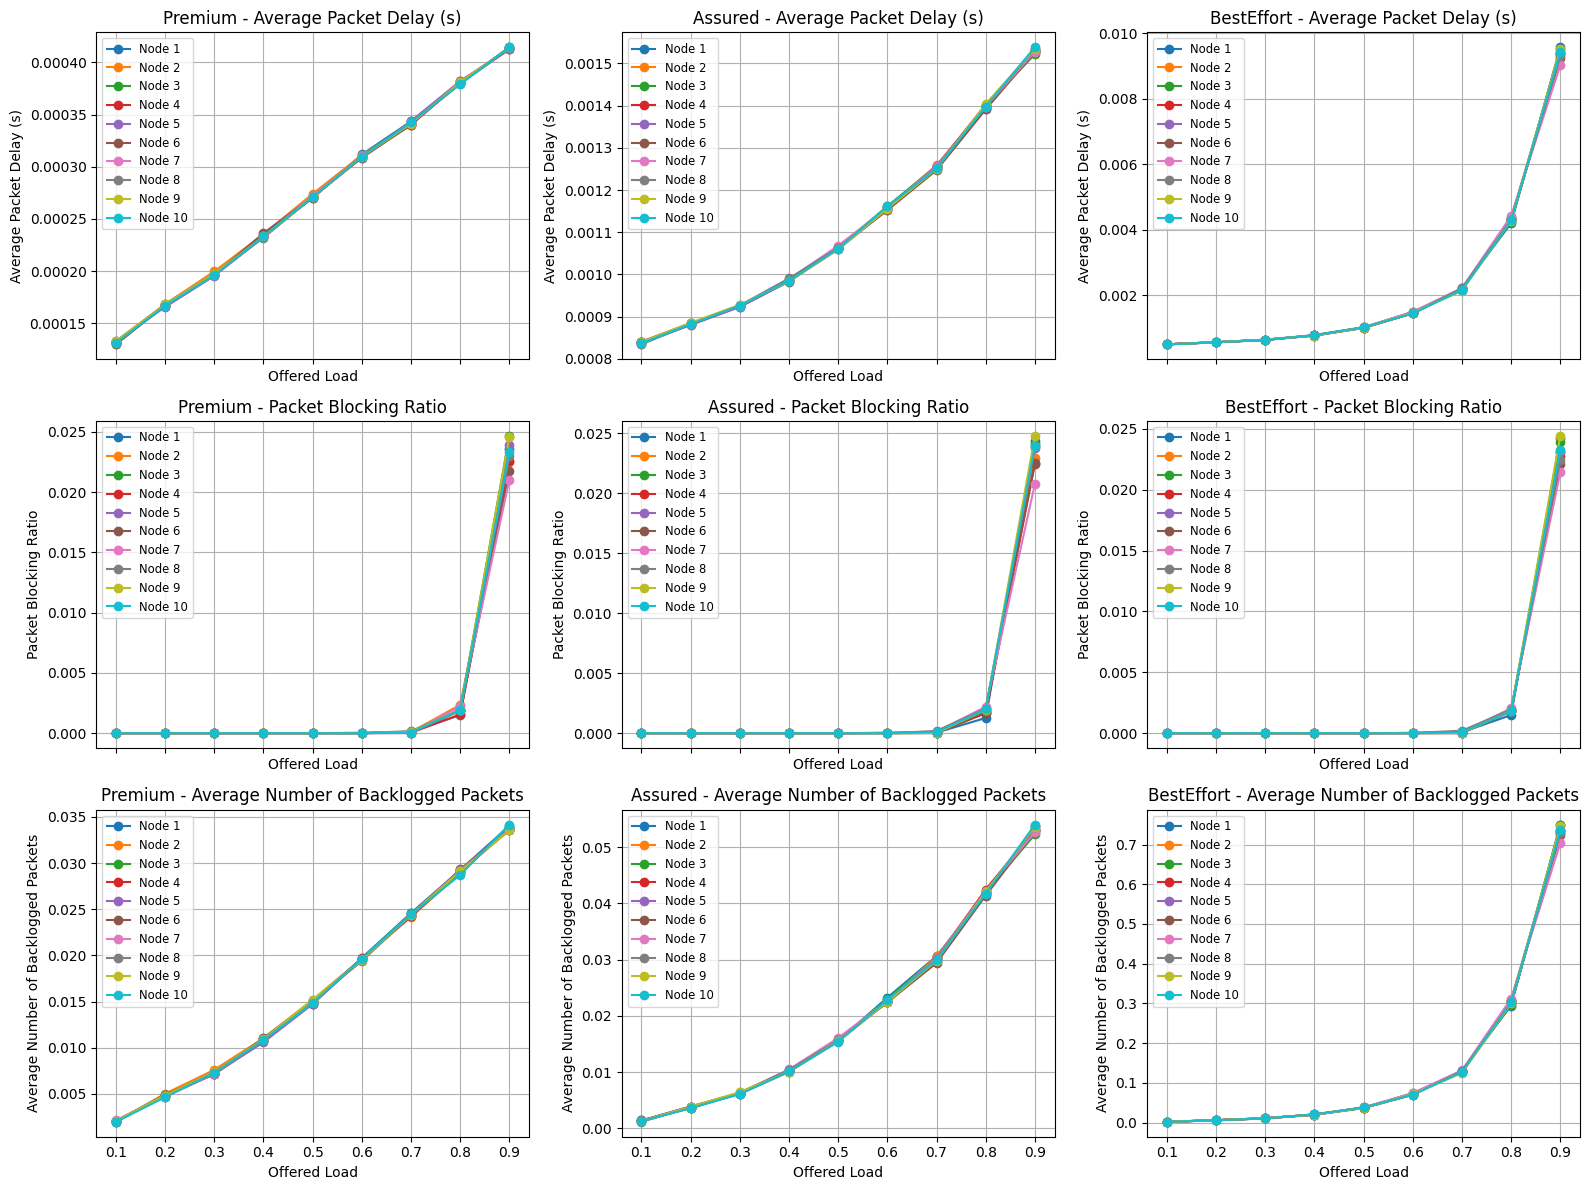

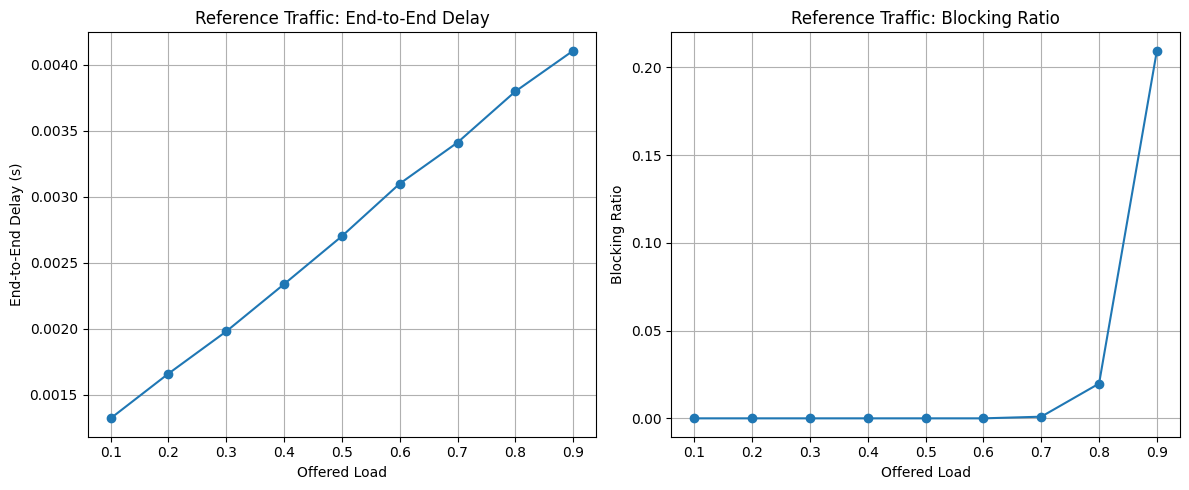

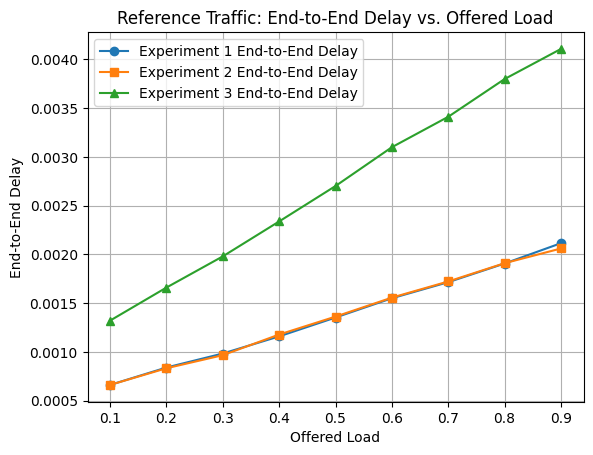

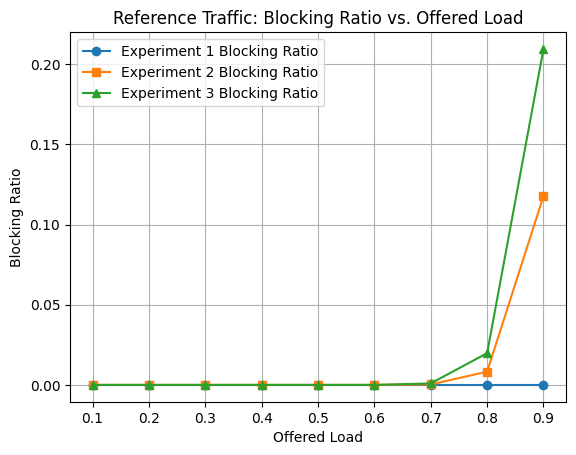

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


# Set the CSV file path for Experiment 3 (update the file name/path as needed)
csv_file = 'results_scenario3.csv'
df_node, df_ref = read_results(csv_file)

# -------------------------------
# 1. Visualization: Node-Level Metrics
# -------------------------------
# For each priority queue, plot:
#   (a) Average Packet Delay,
#   (b) Packet Blocking Ratio,
#   (c) Average Number of Backlogged Packets,
# versus Offered Load for each of the 10 nodes.
metrics = {
    'AvgDelay': 'Average Packet Delay (s)',
    'BlockingRatio': 'Packet Blocking Ratio',
    'AvgBacklog': 'Average Number of Backlogged Packets'
}
queue_types = ['Premium', 'Assured', 'BestEffort']

# Create a 3x3 grid of subplots: rows for each metric and columns for each queue type.
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(16, 12), sharex=True)

for col, queue in enumerate(queue_types):
    # Filter node-level data for the given priority queue.
    df_queue = df_node[df_node['QueueType'] == queue]
    # Sort nodes numerically (here nodes are strings; convert them for ordering)
    nodes = sorted(df_queue['Node'].unique(), key=lambda x: int(x))
    
    for row, metric in enumerate(metrics.keys()):
        ax = axs[row, col]
        for node in nodes:
            # For each node, sort by offered load and plot the metric.
            subset = df_queue[df_queue['Node'] == node].sort_values('OfferedLoad')
            ax.plot(subset['OfferedLoad'], subset[metric], marker='o', label=f'Node {node}')
        ax.set_title(f'{queue} - {metrics[metric]}')
        ax.set_xlabel('Offered Load')
        ax.set_ylabel(metrics[metric])
        ax.grid(True)
        ax.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()

# -------------------------------
# 2. Visualization: Reference Traffic Metrics
# -------------------------------
# The reference data provides overall end-to-end delay and blocking ratio.
# Pivot the reference dataframe so each metric becomes a column.
ref_pivot = df_ref.pivot(index='OfferedLoad', columns='Metric', values='Value').reset_index()

fig2, axs2 = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# (d) End-to-End Delay versus Offered Load.
axs2[0].plot(ref_pivot['OfferedLoad'], ref_pivot['EndToEndDelay'], marker='o', linestyle='-')
axs2[0].set_title('Reference Traffic: End-to-End Delay')
axs2[0].set_xlabel('Offered Load')
axs2[0].set_ylabel('End-to-End Delay (s)')
axs2[0].grid(True)
# If a theoretical delay curve is available, it could be overlaid:
# axs2[0].axhline(y=theoretical_delay, color='red', linestyle='--', label='Theoretical Average')
# axs2[0].legend()

# (e) Overall Blocking Ratio for Reference Traffic versus Offered Load.
axs2[1].plot(ref_pivot['OfferedLoad'], ref_pivot['BlockingRatio'], marker='o', linestyle='-')
axs2[1].set_title('Reference Traffic: Blocking Ratio')
axs2[1].set_xlabel('Offered Load')
axs2[1].set_ylabel('Blocking Ratio')
axs2[1].grid(True)

plt.tight_layout()
plt.show()


# -------------------------------------------
# 3. Comparison of Reference Traffic between Scenario 1 and Scenario 2
# -------------------------------------------

# Read CSV files (adjust file paths as needed)
df1 = pd.read_csv("results_scenario1.csv")
df2 = pd.read_csv("results_scenario2.csv")
df3 = pd.read_csv("results_scenario3.csv")

# Convert 'Node' to string so that 'Reference' rows are not cast to numeric
df1['Node'] = df1['Node'].astype(str)
df2['Node'] = df2['Node'].astype(str)
df3['Node'] = df3['Node'].astype(str)

# Ensure OfferedLoad is numeric
df1['OfferedLoad'] = df1['OfferedLoad'].astype(float)
df2['OfferedLoad'] = df2['OfferedLoad'].astype(float)
df3['OfferedLoad'] = df3['OfferedLoad'].astype(float)


# Separate reference and non-reference rows
df1_ref = df1[df1['Node'] == "Reference"].copy()
df1_nonref = df1[df1['Node'] != "Reference"].copy()
df2_ref = df2[df2['Node'] == "Reference"].copy()
df2_nonref = df2[df2['Node'] != "Reference"].copy()
df3_ref = df3[df3['Node'] == "Reference"].copy()



df1_ref_delay = df1_ref[df1_ref['QueueType'] == "EndToEndDelay"]
df1_ref_block = df1_ref[df1_ref['QueueType'] == "BlockingRatio"]

df2_ref_delay = df2_ref[df2_ref['QueueType'] == "EndToEndDelay"]
df2_ref_block = df2_ref[df2_ref['QueueType'] == "BlockingRatio"]

df3_ref_delay = df3_ref[df3_ref['QueueType'] == "EndToEndDelay"]
df3_ref_block = df3_ref[df3_ref['QueueType'] == "BlockingRatio"]

# Plot End-to-End Delay comparison
plt.figure()
plt.plot(df1_ref_delay['OfferedLoad'], df1_ref_delay['AvgDelay'], marker='o', label='Experiment 1 End-to-End Delay')
plt.plot(df2_ref_delay['OfferedLoad'], df2_ref_delay['AvgDelay'], marker='s', label='Experiment 2 End-to-End Delay')
plt.plot(df3_ref_delay['OfferedLoad'], df3_ref_delay['AvgDelay'], marker='^', label='Experiment 3 End-to-End Delay')
plt.xlabel("Offered Load")
plt.ylabel("End-to-End Delay")
plt.title("Reference Traffic: End-to-End Delay vs. Offered Load")
plt.legend()
plt.grid(True)
plt.show()

# Plot Blocking Ratio comparison for reference traffic
plt.figure()
plt.plot(df1_ref_block['OfferedLoad'], df1_ref_block['AvgDelay'], marker='o', label='Experiment 1 Blocking Ratio')
plt.plot(df2_ref_block['OfferedLoad'], df2_ref_block['AvgDelay'], marker='s', label='Experiment 2 Blocking Ratio')
plt.plot(df3_ref_block['OfferedLoad'], df3_ref_block['AvgDelay'], marker='^', label='Experiment 3 Blocking Ratio')
plt.xlabel("Offered Load")
plt.ylabel("Blocking Ratio")
plt.title("Reference Traffic: Blocking Ratio vs. Offered Load")
plt.legend()
plt.grid(True)
plt.show()



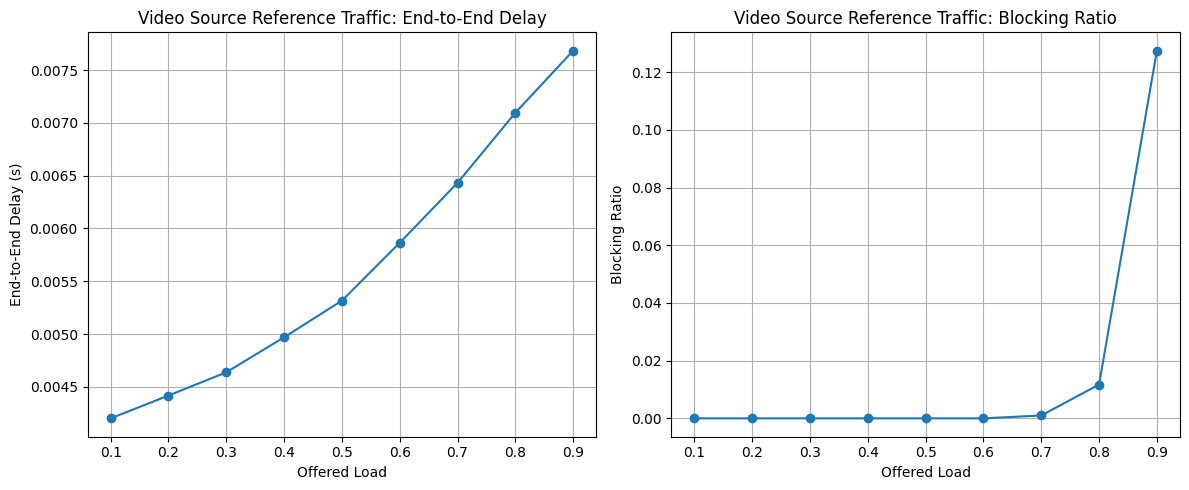

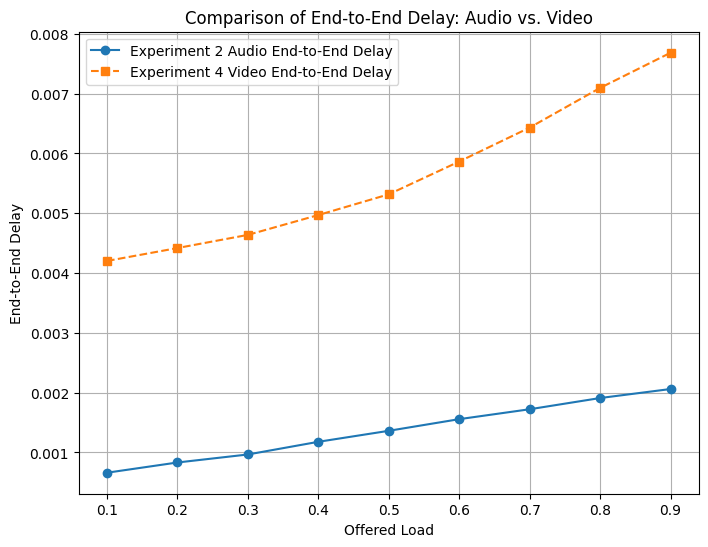

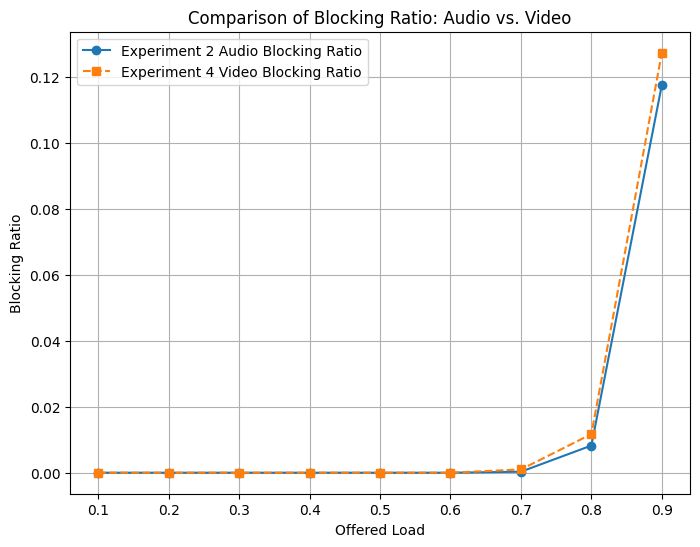

In [15]:
# Load the Experiment 4 CSV file (update the file path as needed)
csv_file = 'results_scenario4.csv'
df_node, df_ref = read_results(csv_file)

# -----------------------------------------
# Visualization for Reference Traffic Metrics
# -----------------------------------------
# For Experiment 4 (video source), we are interested in:
# (d) End-to-End Delay vs. Offered Load and
# (e) Overall Blocking Ratio vs. Offered Load.
# These can then be compared with Experiment 2 (audio source).

# Pivot the reference data so that each metric becomes a column
ref_pivot = df_ref.pivot(index='OfferedLoad', columns='Metric', values='Value').reset_index()

# Create a figure with two subplots side by side.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Plot (d) End-to-End Delay vs Offered Load
ax1.plot(ref_pivot['OfferedLoad'], ref_pivot['EndToEndDelay'], marker='o', linestyle='-')
ax1.set_title('Video Source Reference Traffic: End-to-End Delay')
ax1.set_xlabel('Offered Load')
ax1.set_ylabel('End-to-End Delay (s)')
ax1.grid(True)

# Plot (e) Overall Blocking Ratio vs Offered Load
ax2.plot(ref_pivot['OfferedLoad'], ref_pivot['BlockingRatio'], marker='o', linestyle='-')
ax2.set_title('Video Source Reference Traffic: Blocking Ratio')
ax2.set_xlabel('Offered Load')
ax2.set_ylabel('Blocking Ratio')
ax2.grid(True)

plt.tight_layout()
plt.show()


# -------------------------------------------
# 3. Comparison of Reference Traffic between Audio and Video
# -------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# Load simulation results for audio (from part 2) and video (from part 4)
# Adjust the file paths as necessary.
audio_df = pd.read_csv("results_scenario2.csv")
video_df = pd.read_csv("results_scenario4.csv")

# Extract only the reference traffic rows (assuming 'Node' equals 'Reference')
audio_ref = audio_df[audio_df['Node'] == 'Reference']
video_ref = video_df[video_df['Node'] == 'Reference']

# For both audio and video, the reference traffic statistics are stored with:
# 'QueueType' equal to "EndToEndDelay" for delay and "BlockingRatio" for blocking.
audio_delay = audio_ref[audio_ref['QueueType'] == "EndToEndDelay"]
audio_block = audio_ref[audio_ref['QueueType'] == "BlockingRatio"]

video_delay = video_ref[video_ref['QueueType'] == "EndToEndDelay"]
video_block = video_ref[video_ref['QueueType'] == "BlockingRatio"]

# Plot End-to-End Delay comparison
plt.figure(figsize=(8,6))
plt.plot(audio_delay['OfferedLoad'], audio_delay['AvgDelay'], marker='o', linestyle='-', label='Experiment 2 Audio End-to-End Delay')
plt.plot(video_delay['OfferedLoad'], video_delay['AvgDelay'], marker='s', linestyle='--', label='Experiment 4 Video End-to-End Delay')
plt.xlabel("Offered Load")
plt.ylabel("End-to-End Delay")
plt.title("Comparison of End-to-End Delay: Audio vs. Video")
plt.legend()
plt.grid(True)
plt.show()

# Plot Blocking Ratio comparison
plt.figure(figsize=(8,6))
plt.plot(audio_block['OfferedLoad'], audio_block['AvgDelay'], marker='o', linestyle='-', label='Experiment 2 Audio Blocking Ratio')
plt.plot(video_block['OfferedLoad'], video_block['AvgDelay'], marker='s', linestyle='--', label='Experiment 4 Video Blocking Ratio')
plt.xlabel("Offered Load")
plt.ylabel("Blocking Ratio")
plt.title("Comparison of Blocking Ratio: Audio vs. Video")
plt.legend()
plt.grid(True)
plt.show()

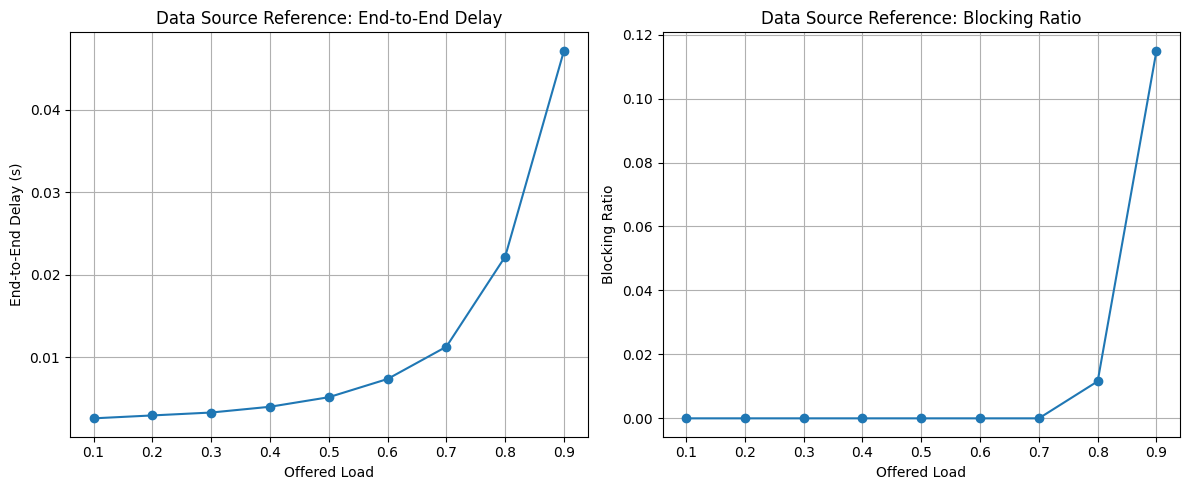

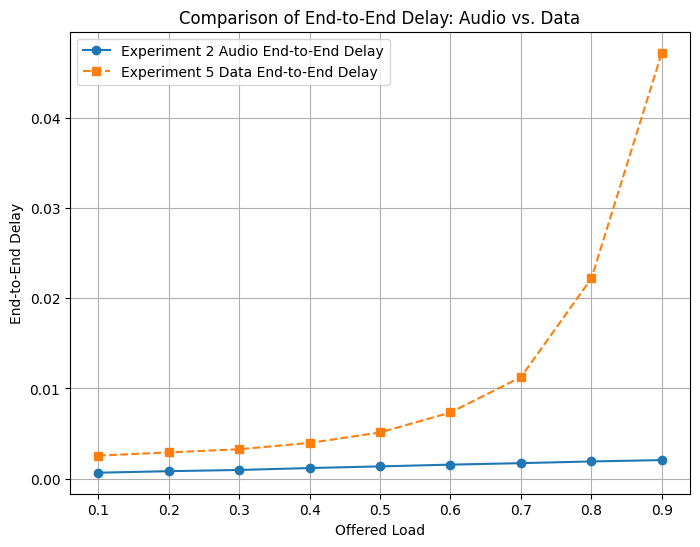

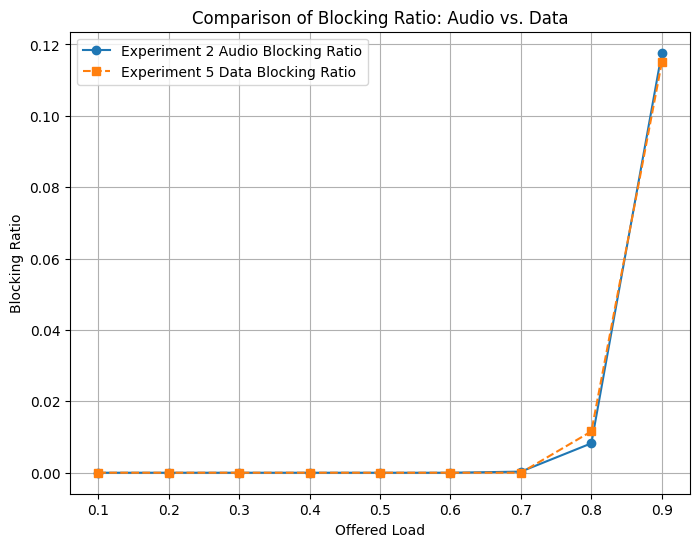

In [19]:
# Specify the CSV file path for Experiment 5 (update the path if needed)
csv_file = 'results_scenario5.csv'
df_node, df_ref = read_results(csv_file)

# --------------------------------------------------
# Visualization: Reference Traffic Metrics for Experiment 5
# --------------------------------------------------
# For Experiment 5, the reference source is configured as a data source.
# We are interested in:
#    (d) End-to-End Delay vs. Offered Load, and
#    (e) Overall Blocking Ratio vs. Offered Load.
#
# These plots can be compared to the corresponding plots from Experiment 2
# (with an audio source) to understand how using a data source changes the performance.
#
# Pivot the reference data so that each metric becomes a separate column.
ref_pivot = df_ref.pivot(index='OfferedLoad', columns='Metric', values='Value').reset_index()

# Create a figure with two side-by-side subplots.
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Plot (d): End-to-End Delay vs. Offered Load.
ax1.plot(ref_pivot['OfferedLoad'], ref_pivot['EndToEndDelay'], marker='o', linestyle='-')
ax1.set_title('Data Source Reference: End-to-End Delay')
ax1.set_xlabel('Offered Load')
ax1.set_ylabel('End-to-End Delay (s)')
ax1.grid(True)

# Plot (e): Overall Blocking Ratio vs. Offered Load.
ax2.plot(ref_pivot['OfferedLoad'], ref_pivot['BlockingRatio'], marker='o', linestyle='-')
ax2.set_title('Data Source Reference: Blocking Ratio')
ax2.set_xlabel('Offered Load')
ax2.set_ylabel('Blocking Ratio')
ax2.grid(True)

plt.tight_layout()
plt.show()


# -------------------------------------------
# 3. Comparison of Reference Traffic between Audio and Video
# -------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

# Load simulation results for audio (from part 2) and video (from part 4)
# Adjust the file paths as necessary.
audio_df = pd.read_csv("results_scenario2.csv")
video_df = pd.read_csv("results_scenario5.csv")

# Extract only the reference traffic rows (assuming 'Node' equals 'Reference')
audio_ref = audio_df[audio_df['Node'] == 'Reference']
video_ref = video_df[video_df['Node'] == 'Reference']

# For both audio and video, the reference traffic statistics are stored with:
# 'QueueType' equal to "EndToEndDelay" for delay and "BlockingRatio" for blocking.
audio_delay = audio_ref[audio_ref['QueueType'] == "EndToEndDelay"]
audio_block = audio_ref[audio_ref['QueueType'] == "BlockingRatio"]

video_delay = video_ref[video_ref['QueueType'] == "EndToEndDelay"]
video_block = video_ref[video_ref['QueueType'] == "BlockingRatio"]

# Plot End-to-End Delay comparison
plt.figure(figsize=(8,6))
plt.plot(audio_delay['OfferedLoad'], audio_delay['AvgDelay'], marker='o', linestyle='-', label='Experiment 2 Audio End-to-End Delay')
plt.plot(video_delay['OfferedLoad'], video_delay['AvgDelay'], marker='s', linestyle='--', label='Experiment 5 Data End-to-End Delay')
plt.xlabel("Offered Load")
plt.ylabel("End-to-End Delay")
plt.title("Comparison of End-to-End Delay: Audio vs. Data")
plt.legend()
plt.grid(True)
plt.show()

# Plot Blocking Ratio comparison
plt.figure(figsize=(8,6))
plt.plot(audio_block['OfferedLoad'], audio_block['AvgDelay'], marker='o', linestyle='-', label='Experiment 2 Audio Blocking Ratio')
plt.plot(video_block['OfferedLoad'], video_block['AvgDelay'], marker='s', linestyle='--', label='Experiment 5 Data Blocking Ratio')
plt.xlabel("Offered Load")
plt.ylabel("Blocking Ratio")
plt.title("Comparison of Blocking Ratio: Audio vs. Data")
plt.legend()
plt.grid(True)
plt.show()


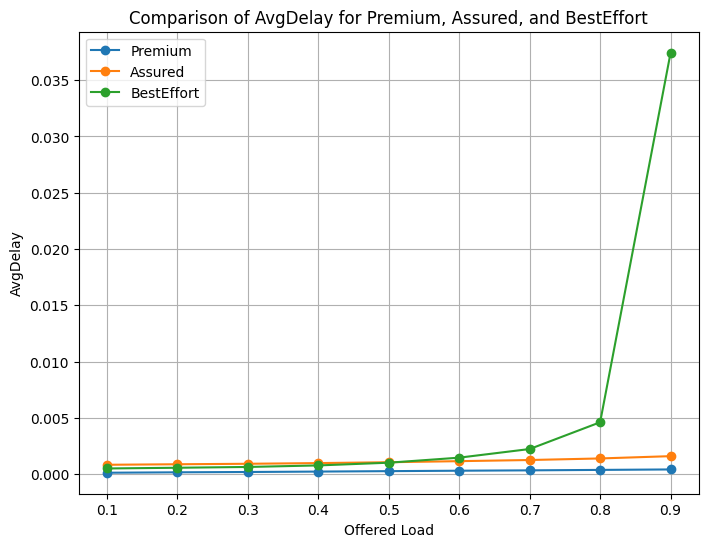

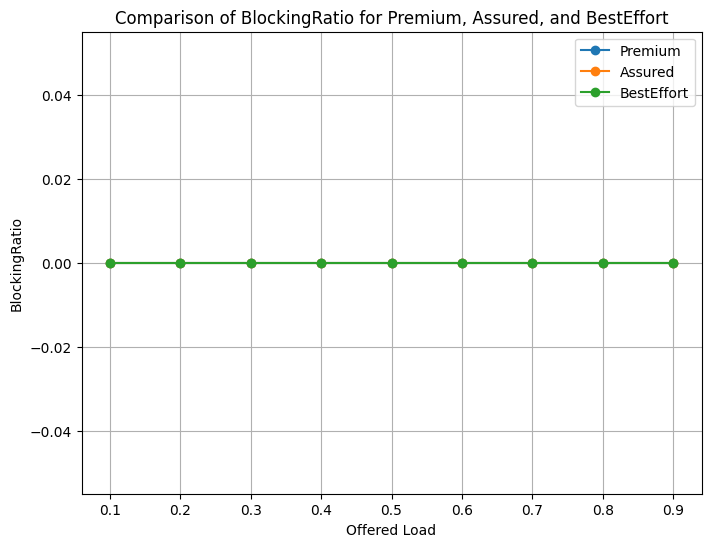

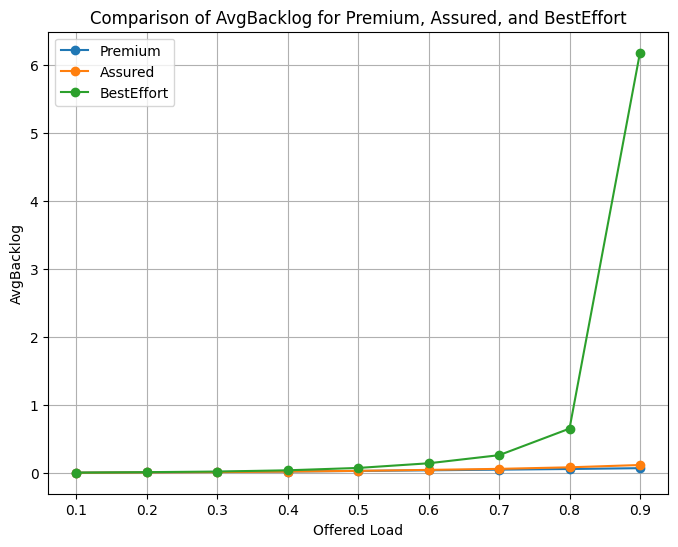

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the simulation results CSV file
df = pd.read_csv("results_scenario1.csv")

# Exclude the reference traffic rows if present
df_nonref = df[df['Node'] != "Reference"]

# Define the metrics and queue types to compare
metrics = ["AvgDelay", "BlockingRatio", "AvgBacklog"]
queue_types = ["Premium", "Assured", "BestEffort"]

# Loop over each metric to create a separate plot
for metric in metrics:
    plt.figure(figsize=(8, 6))
    # Plot the curve for each queue type by averaging over nodes
    for qt in queue_types:
        subset = df_nonref[df_nonref['QueueType'] == qt]
        # Group by OfferedLoad and take the mean of the metric
        subset_mean = subset.groupby("OfferedLoad")[metric].mean().reset_index()
        plt.plot(subset_mean["OfferedLoad"], subset_mean[metric], marker="o", label=qt)
    plt.xlabel("Offered Load")
    plt.ylabel(metric)
    plt.title(f"Comparison of {metric} for Premium, Assured, and BestEffort")
    plt.legend()
    plt.grid(True)
    plt.show()
